In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import pickle

use_cuda = torch.cuda.is_available()

In [2]:
reviews = pd.read_csv("./Reviews.csv")[:1000]
reviews = reviews.dropna()
reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator',
                        'Score','Time'], 1)
reviews = reviews.reset_index(drop=True)
reviews.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [4]:
def clean_text(text, remove_stopwords = False):
    text = text.lower()
    
    if True:
        text = text.split()
        new_text = []
        
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    
    return text

In [5]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = []
    temp = []
    for i in range(len(reviews.Summary)):
        var1 = clean_text(reviews.Summary[i], remove_stopwords=False)
        var2 = clean_text(reviews.Text[i], remove_stopwords=False)
        temp = [var1,var2]
        pairs.append(temp)
#     pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, input_lang, pairs


In [8]:
MAX_LENGTH = 200


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 1000 sentence pairs
Trimmed to 930 sentence pairs
Counting words...
Counted words:
fra 5179
fra 5179
['toy was typical quality i expected  i got taken for a major ride on the shipping ', 'penguin pooper']


In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=2):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result


In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=2, dropout_p=0.4, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result


In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)


In [13]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < 1 else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


In [15]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01,epochs=10):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    save_pairs = [random.choice(pairs)
                      for i in range(n_iters)]
    training_pairs = [variablesFromPair(i)
                      for i in save_pairs]
    criterion = nn.NLLLoss()
    
    inter = 0
    for ep in range(0):
        
        for iter in range(1, n_iters + 1):
            inter += 1
            training_pair = training_pairs[iter - 1]
            input_variable = training_pair[0]
            target_variable = training_pair[1]

            loss = train(input_variable, target_variable, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

            if inter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, inter / n_iters),
                                             inter, inter / n_iters * 100, print_loss_avg))

            if inter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
                
        pickle.dump(encoder,open("./5000_hack_encoder_{}.pkl".format(ep),"wb"))
        pickle.dump(decoder,open("./5000_hack_attn_decoder_{}.pkl".format(ep),"wb"))
        
        print("Plot for epoch:",ep+1)
        showPlot(plot_losses)
        
    showPlot(plot_losses)
    return save_pairs

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

In [18]:
def evaluateRandomly(encoder, decoder, n=10 ,pairs=pairs):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


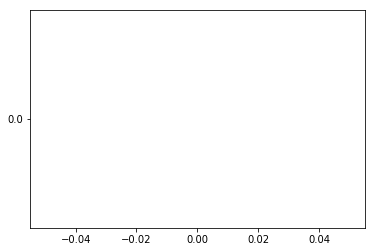

In [19]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               1, dropout_p=0.4)

if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

pair = trainIters(encoder1, attn_decoder1, 2000, print_every=100)

In [23]:
en = pickle.load(open("./encoder_9.pkl","rb"))
de = pickle.load(open("./attn_decoder_9.pkl","rb"))
# pickle.dump(pair,open("./pair.pkl","wb"))

In [24]:
print(pair)
# for p in pair:
#     output_lang.index2word[]

[['love these chips  and i do not even like black beans  very tasty  yum   plus  good for you ', 'delicious and additive'], ['a watered down perversion of the acai berry <br  ><br  >this juice comes on strong and harsh  with tart aftertaste and no texture <br  ><br  >that s because it is mostly apple juice  grape juice  pomegranate juice  blackberry juice  blueberry juice  and tart cherry juice  oh yeah there is some acai berry juice mixed into this concoction <br  ><br  >you shall not find that distinctive smooth chocolaty acai flavor here  there is no milky mouth pleasing texture neither  for that exotic unique acai experience try zola or samzon brands <br  ><br  >i m not saying that this lakewood juice product is not nutritious  that is not my point  i am saying that it is a juice blend that does not taste anything like the real acai juice ', 'perversion of taste'], ['yes  they are good  however  they are absolutely inundated with the flavoring stuff  which is initially satisfying t

In [26]:
evaluateRandomly(en, de, pairs=pair)

> my scotties were full of hot spots and when i used this within a week all the hot spots were gone  the smell is kinda strong  but not bad  it is tolerablel 
= miracle
< miracle <EOS>

> i have bought allot of different flavors and this happens to be one of my favorites and will be getting more soon
= great flavor
< great flavor <EOS>

> salt   vinegar chips are my favorite flavor so i think i have tried every brand out there  these are by far the best  i also like them because the sodium content is not very high like some of the others and they are not excessively greasy  they seem to have the right balance of the salt and vinegar taste 
= best salt   vinegar chips out there 


/home/maitreya/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  
/home/maitreya/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().


< best    vinegar chips <EOS>

> i tried to find israeli couscous in a number of upsacale grocery stores and no luck  so i decided to try good ole amazon com and selected this product  it is so good  add a few herbs and it is a great side dish  or add more and make a  pasta type  salad so very good  i am hooked  great flavor and so easy to prepare 
= wow
< wow <EOS>

> salt   vinegar chips are my favorite flavor so i think i have tried every brand out there  these are by far the best  i also like them because the sodium content is not very high like some of the others and they are not excessively greasy  they seem to have the right balance of the salt and vinegar taste 
= best salt   vinegar chips out there 
< best     vinegar chips <EOS>

> well being the big red fan that i am  i bought some of this  first of all let me tell you the price is amazing  i mean where else can you get this type of deal in saudi arabia  everyone in village loved it  of course now they are wondering when the

In [32]:
# import pickle

# pickle.dump(encoder1,open("./encoder_over.pkl","wb"))
# pickle.dump(attn_decoder1,open("./attn_decoder_over.pkl","wb"))

In [26]:
trainIters(encoder1, attn_decoder1, 2000, print_every=100)

0m 36s (- 11m 29s) (100 5%) 3.6016
1m 19s (- 11m 58s) (200 10%) 3.3846
2m 4s (- 11m 44s) (300 15%) 3.3162
2m 44s (- 10m 56s) (400 20%) 3.5434
3m 29s (- 10m 27s) (500 25%) 3.4078
4m 13s (- 9m 51s) (600 30%) 3.0723
4m 54s (- 9m 6s) (700 35%) 3.1266
5m 29s (- 8m 13s) (800 40%) 3.2033
5m 53s (- 7m 12s) (900 45%) 3.4083
6m 18s (- 6m 18s) (1000 50%) 3.3017
6m 41s (- 5m 28s) (1100 55%) 3.2639
7m 7s (- 4m 44s) (1200 60%) 3.2141
7m 32s (- 4m 3s) (1300 65%) 3.1197
7m 59s (- 3m 25s) (1400 70%) 3.2455
8m 41s (- 2m 53s) (1500 75%) 3.0461
9m 24s (- 2m 21s) (1600 80%) 2.9464
10m 9s (- 1m 47s) (1700 85%) 2.8714
10m 49s (- 1m 12s) (1800 90%) 2.7677
11m 30s (- 0m 36s) (1900 95%) 2.8453
12m 13s (- 0m 0s) (2000 100%) 2.8086
12m 56s (- -1m 23s) (2100 105%) 2.4586
13m 40s (- -2m 45s) (2200 110%) 2.3271
14m 24s (- -2m 7s) (2300 114%) 2.2803
15m 4s (- -3m 29s) (2400 120%) 2.3691
15m 48s (- -4m 50s) (2500 125%) 2.3486
16m 32s (- -4m 10s) (2600 130%) 2.0075
17m 13s (- -5m 32s) (2700 135%) 2.1800
17m 55s (- -6m 

CuDNNError: 4: b'CUDNN_STATUS_INTERNAL_ERROR'

In [28]:
trainIters(encoder1, attn_decoder1, 2000, print_every=100)

RuntimeError: cuda runtime error (4) : unspecified launch failure at /pytorch/torch/lib/THC/generic/THCTensorCopy.c:20